In [105]:
import pandas as pd
import requests
import numpy as np
import unidecode
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import json

# Part 0: A class to handle GraphQL queries

In [106]:

class GraphqlQuery:
    def __init__(self, contents : dict[str : list[str]], url : str):
        self._contents = {}
        self.add(contents)
        self.url = url
    
    #method to add further tables and/or columns to the current query
    def add(self, new_contents : dict[str : list[str]]):
        
        #validate passed arguments
        if not isinstance(new_contents, dict):
            raise ValueError("Contents must be passed as dictionary")
        
        for key, val in new_contents.items() :
            if not isinstance(key, str):
                raise ValueError("Table arguments must be passed as strings")
            if not isinstance(val, list):
                raise ValueError("Set of columns must be a list")
            if not all(isinstance(column, str) for column in val):
                raise ValueError("Column arguments must be passed as strings")
            
        for table, columns in new_contents.items():
            if table not in self._contents:
                self._contents[table] = columns
            else:
                self._contents[table].extend(columns)

    #property to store current contents od query in dict format
    @property
    def contents(self):
        return self._contents
    
    #property to store finished query in graphql format
    @property
    def query(self):
        query_str =  ["query Myquery {"]
        for index, (table, columns) in enumerate(self._contents.items()):
            subquery = []
            subquery.append(table)
            subquery.append('{')
            subquery.extend(columns)
            query_str.extend(subquery)
            if index != 0: query_str +="}"
        query_str +="}}"
        
        return " ".join(query_str)
    ''
    def __str__(self):
        return self._query
     
    @classmethod
    def select(cls, contents : dict[str : list[str]]):
        return cls(contents)

    #method to perform get request to graphql api
    def get_data(self):
        body = {"query" : self.query}
        try:
            response = requests.post(self.url, json=body,timeout=180)
            response.raise_for_status()
            data = response.json()
            return pd.json_normalize(data['data'][list(self._contents)[0]])
        except Exception as e:
                print(f"Error fetching data: {e}")


# Part 1: Salary Data Analysis

### 1. Wrangling of player data

In this section the graphql API for NBA statistics is queried for player and team information via GraphqlQuery class. Additional data manipulation steps include:  
- Elimination of unwanted characters and conversion of string formats in player names (e.g. change "ć" to "c") in order to avoid problems with merges.
- Mapping of team abbreviations as these are not consistent in the API tables *teams* and *playerPerGame*.
- Merging of both tables into one comprehensive dataframe containing all necessary information.

***As of 20.10.2025, the GraphQL API stopped working. We are therefore forced to substitute the data therein by a flatfile, which was also downloaded from Kaggle.***

The goal of this section, however, remains the same. That is, to create a single dataframe containing all necessary player statistics.

In [107]:
# url = 'https://nbaapi.com/graphql/'

# #set down tables and columns to query from nbaapi
# query_teams = {
#     'team' :
#     ['teamName','teamAbbr', 'season', 'wins']
#     }

# query_players = {
#     'playerPerGame' : 
#     ['playerName', 'team', 'age', 'season', 'games', 'minutesPg', 'points', 'ftPercent', 'assists', 'totalRb', 'steals', 'turnovers', 'blocks']
#     }

# #define Graphqlquery objects
# player_data = GraphqlQuery(query_players, url)
# team_data = GraphqlQuery(query_teams, url)

# #get data from the api and store it in respective dataframes
# player_stats = player_data.get_data()
# team_stats = team_data.get_data()

# #replace "*" and handle string format of player names
# team_stats.teamName = team_stats.teamName.str.replace('*', '')

# player_stats.playerName = player_stats.playerName.str.replace('*', '')
# player_stats.playerName = player_stats.playerName.apply(unidecode.unidecode)

# player_stats = player_stats[player_stats.team != 'TOT']

# #set down team abbreviations that need to be changed
# team_names = {
#     'BRK' : 'NJN',
#     'NOP' : 'NOH',
#     'CHO' : 'CHA',
#     'SEA' : 'OKC',
#     'NOK' : 'CHA',
#     'CHH' : 'CHA',
#     'VAN' : 'MEM',
#     'WSB' : 'WAS'
# }
# player_stats = player_stats.replace({'team' : team_names})

# #merge player and team statistics into one dataframe
# player_stats = player_stats.merge(
#     team_stats,
#     how='inner',
#     left_on=['season', 'team'],
#     right_on=['season', 'teamAbbr']
# ).drop(['teamAbbr'], axis=1)

# player_stats.head()

In [121]:
#read in alternative datasource and change column names to match the ones used in the rest of the code
columns = ['season', 'player', 'team_id', 'age', 'g', 'mp_per_g', 'pts_per_g', 'ft_pct',
           'ast_per_g', 'trb_per_g', 'stl_per_g', 'tov_per_g', 'blk_per_g']

player_stats = pd.read_csv('NBA_Dataset.csv', usecols=columns)
player_stats = player_stats.rename(columns=
    {'player' : 'playerName',
     'team_id' : 'team_abbr',
     'g' : 'games', 
     'mp_per_g' : 'minutesPg', 
     'pts_per_g' : 'points', 
     'ft_pct' : 'ftPercent', 
     'ast_per_g' : 'assists', 
     'trb_per_g' : 'totalRb', 
     'stl_per_g' : 'steals', 
     'tov_per_g' : 'turnovers', 
     'blk_per_g' : 'blocks'
    })

player_stats.head()

,season,playerName,age,team_abbr,games,minutesPg,ftPercent,totalRb,assists,steals,blocks,turnovers,points
0,1982,Kareem Abdul-Jabbar,34,LAL,76,35.2,0.706,8.7,3.0,0.8,2.7,3.0,23.9
1,1982,Alvan Adams,27,PHO,79,30.3,0.781,7.4,4.5,1.4,1.0,2.5,15.1
2,1982,Mark Aguirre,22,DAL,51,28.8,0.680,4.9,3.2,0.7,0.4,2.6,18.7
3,1982,Danny Ainge,22,BOS,53,10.6,0.862,1.1,1.6,0.7,0.1,1.0,4.1
4,1982,Tiny Archibald,33,BOS,68,31.9,0.747,1.7,8.0,0.8,0.0,2.6,12.6


### 2. Wrangling of salary data

The goal of this section is to read in salary data and bring it into an appropiate form.  
Because the data was in part not complete, several data sources where needed. Consequently, some of data manipulation was necessary to merge the data into one single dataframe.  
All of the data in this section was sourced from Kaggle.  
  
Steps taken:  
- Processed salary data for the timeframes 2000 to 2025 and 1995 to 2018.
- Because above datasets do not contain team names or team name abbreviations, got these from the graphQL API and added them.
- Merged all data together to form one comprehensive dataframe containing salary data for all seasons from 1995 to 2025.

In [109]:
# Salary datasets do not contain both team names and abbreviations
# we use our class to store these in dataframe and later map them

# url = 'https://nbaapi.com/graphql/'

# #call graphql class
# team_names = GraphqlQuery(
#     {'team' : ['teamName','teamAbbr']},
#       url
# )

# #get data from api and prepare data for mapping of team names
# team_names = team_names.get_data()
# team_names.teamName = team_names.teamName.str.replace('*', '')
# team_names = team_names.replace(
#     {'teamAbbr' : {'NJN' : 'BRK','NOH' : 'NOP','CHA' : 'CHO'}}
# )

# #create dictionary for mapping
# team_names_dict = (team_names.drop_duplicates(subset=['teamAbbr'])
#                    .set_index('teamAbbr')['teamName'].to_dict())

In [110]:
#both datasets contain different timeframes
#we therefore use two datasets and concatenate them

#read data, extract necessary timeframe and 
df_salary_2 = pd.read_csv("NBA Player Stats and Salaries_2000-2025.csv", usecols=['Player', 'Year', 'Salary', 'Team'])
df_salary_2 = df_salary_2[df_salary_2['Year'] > 2018]

#furnish with team names using dictionary defined in previous cell
#df_salary_2['TeamLong'] = df_salary_2['Team'].map(team_names_dict)

#rename columns to match columns of df_salary in preparation of concatenation of both dataframes
df_salary_2 = df_salary_2.rename(
    columns={'Player': 'name', 'Salary' : 'salary', 'Year' : 'year', 'Team' : 'team_abbr', 'TeamLong' : 'team'}
)


In [111]:
#dataset consists of two database style sheets
#we thus have to read both in and perform a merge

df_salary_aux = pd.read_csv('players.csv', sep=',', usecols=['name', 'id'])
df_salary = pd.read_csv('salaries_1985to2018.csv', usecols=['player_id', 'salary', 'season_end', 'team'])

#perform aforementioned merge / join
df_salary = df_salary.merge(
    df_salary_aux,
    how='outer',
    left_on='player_id',
    right_on='id'
).drop(['player_id', 'id'], axis=1) #drop unnecessary colummns

#Add team column with abbreviations by merging with team_names dataframe
# df_salary = df_salary.merge(
#     team_names.drop_duplicates(),
#     how='left',
#     left_on='team',
#     right_on='teamName'
# ).drop(['teamName'], axis=1)

#Many rows contain no salary data, we drop these
df_salary = df_salary[~df_salary.isna().any(axis=1)]

#prepare columns for concatenation with second salary
df_salary = df_salary.rename(columns={'season_end' : 'year', 'teamAbbr' : 'team_abbr'})

#concatenation of both dataframes
df_salary = pd.concat([df_salary, df_salary_2], axis=0).reset_index(drop=True)
df_salary.head()

,salary,year,team,name,team_abbr
0,395000.0,1991.0,Portland Trail Blazers,Alaa Abdelnaby,NaN
1,494000.0,1992.0,Portland Trail Blazers,Alaa Abdelnaby,NaN
2,500000.0,1993.0,Boston Celtics,Alaa Abdelnaby,NaN
3,805000.0,1994.0,Boston Celtics,Alaa Abdelnaby,NaN
4,650000.0,1995.0,Sacramento Kings,Alaa Abdelnaby,NaN


### 3. Plot of salary evolution over the years

In this section the cleaned salary data is used for a first display.  
This consists of a visualisation of the evolution of statistical indicators of the salaries of NBA players over the seasons.
  
In accordance with recent developments like the increase of NBA revenue via enormous TV deals, an increase in the mean compensation of NBA players can be observed. 
This is particularily the case for NBA stars, where the increase is much stronger than that of the mean salary. That this is not only the case for the highest payed player can be derived from the growth of standard deviation and the increasing distance between median and mean.

In [112]:
#aggregate stats per season and sort
salary_stats = (df_salary
                .groupby('year')['salary']
                .agg(['mean', 'median', 'min', 'max', 'std'])
                .reset_index()
                .sort_values('year'))

#find the row index of the max salary per season, then get necessary columns
idx = df_salary.groupby('year')['salary'].idxmax()
max_players = (df_salary.loc[idx, ['year', 'name', 'salary', 'team_abbr']]
               .set_index('year')
               .sort_index())

#do the same for players with min salary per season
idx = df_salary.groupby('year')['salary'].idxmin()
min_players = (df_salary.loc[idx, ['year', 'name', 'salary', 'team_abbr']]
               .set_index('year')
               .sort_index())

#align both frames by year
salary_stats = salary_stats.set_index('year')
max_players = max_players.reindex(salary_stats.index)
min_players = min_players.reindex(salary_stats.index)

#build graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=salary_stats.index,
                         y=salary_stats['mean'],
                         mode='lines+markers',
                         name='Mean',
                         hovertemplate='Season: %{x}<br>Mean: %{y}<extra></extra>'))#

fig.add_trace(go.Scatter(x=salary_stats.index,
                         y=salary_stats['median'],
                         mode='lines+markers',
                         name='Median',
                         hovertemplate='Season: %{x}<br>Median: %{y}<extra></extra>'))

fig.add_trace(go.Scatter(x=salary_stats.index,
                         y=salary_stats['std'],
                         mode='lines+markers',
                         name='Standard Deviation',
                         hovertemplate='Season: %{x}<br>Stand. Deviation: %{y}<extra></extra>'))

# fig.add_trace(go.Scatter(x=salary_stats.index,
#                          y=salary_stats['min'],
#                          text=min_players['name'].to_list(),
#                          mode='lines+markers',
#                          name='Min',
#                          customdata=list(zip(min_players['name'], min_players['team_abbr'])),
#                          hovertemplate='Season: %{x}<br>Min salary: %{y}<br>Player: %{customdata[0]}<br>Team: %{customdata[1]}<extra></extra>'))

fig.add_trace(go.Scatter(x=salary_stats.index,
                         y=salary_stats['max'],
                         mode='lines+markers',
                         name='Max',
                         #20251022_Begin: due to API being down
                         #  customdata = list(zip(max_players['name'], max_players['team_abbr'])),  # per-point player name
                         #  hovertemplate='Season: %{x}<br>Max salary: %{y}<br>Player: %{customdata[0]}<br>Team: %{customdata[1]}<extra></extra>'))
                         customdata = max_players['name'],  # per-point player name
                         hovertemplate='Season: %{x}<br>Max salary: %{y}<br>Player: %{customdata}<br><extra></extra>'))
                         #20251022_Begin

fig.update_layout(title='Salary trends', xaxis_title='Season', yaxis_title='Salary',
                  hovermode='closest')
fig.show()

### 4. Analysis of the relation between player salary and efficiency

In order to carry out the analysis of player salary and efficiency, the following steps were carried out:
- To compute player efficiency, the total and per minute rating of each player was calculated accross seasons, making use of per-game statistics such as points, assists, rebounds, steals, blocks, and turnovers.
- Because the aim of this analysis is to investigate the value of any given player, the total rating is computed by taking the total rating accross all games played. 
- To explore the relationship between performance and player compensation, the efficiency data was merged with the salary information. 
- The analysis was carried out without outlariers, that is, players that played 10 games or less in an entire season.
- A function to visualize the data for a total or per minute rating was defined, with the optional argument of limiting the graph to a single season.
- The visualization includes regression lines to examine trends and correlations. In particular, as salary data is not evenly 
- Lastly, the coefficients of the regression lines for all available seasons where also plotted, in order to further investigate the impact on performance on compensation accross various seasons.

In [113]:
#define dataframe used for carrying out analysis
df_efficiency = player_stats.iloc[:,:13].copy()

#ensure correct data types
cols_to_numeric = ['points', 'assists', 'totalRb', 'steals', 'blocks', 'turnovers', 'minutesPg']
df_efficiency[cols_to_numeric] = df_efficiency[cols_to_numeric].apply(pd.to_numeric, errors="coerce")

#compute ratings, total and per minute
df_efficiency = df_efficiency.assign(
    rating = (
        df_efficiency["points"]
      + df_efficiency["assists"]
      + df_efficiency["totalRb"]
      + df_efficiency["steals"]
      + df_efficiency["blocks"]
      - df_efficiency["turnovers"]
    ),
    ratingPm = lambda x: np.where(x["minutesPg"] != 0, x["rating"] / x["minutesPg"], 0), #default to zero 
    ratingTotal = lambda x: x['rating'] * x['games']
)

df_efficiency.sort_values(by='ratingTotal', ascending = False)

,season,playerName,age,team_abbr,games,minutesPg,ftPercent,totalRb,assists,steals,blocks,turnovers,points,rating,ratingPm,ratingTotal
14924,2017,Russell Westbrook,28,OKC,81,34.6,0.845,10.7,10.4,1.6,0.4,5.4,31.6,49.3,1.424855,3993.3
2067,1988,Michael Jordan,24,CHI,82,40.4,0.841,5.5,5.9,3.2,1.6,3.1,35.0,48.1,1.190594,3944.2
2416,1989,Michael Jordan,25,CHI,81,40.2,0.850,8.0,8.0,2.9,0.8,3.6,32.5,48.6,1.208955,3936.6
1727,1987,Michael Jordan,23,CHI,82,40.0,0.857,5.2,4.6,2.9,1.5,3.3,37.1,48.0,1.200000,3936.0
2775,1990,Michael Jordan,26,CHI,82,39.0,0.848,6.9,6.3,2.8,0.7,3.0,33.6,47.3,1.212821,3878.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1833,1987,John Schweitz,26,DET,3,2.3,NaN,0.3,0.0,0.0,0.0,0.7,0.0,-0.4,-0.173913,-1.2
10017,2007,Mile Ilić,22,NJN,5,1.2,NaN,0.2,0.0,0.0,0.0,0.6,0.0,-0.4,-0.333333,-2.0
10089,2007,Chris McCray,22,MIL,5,2.4,NaN,0.0,0.0,0.0,0.0,0.4,0.0,-0.4,-0.166667,-2.0
9542,2006,Nenê,23,DEN,1,3.0,NaN,0.0,0.0,0.0,0.0,2.0,0.0,-2.0,-0.666667,-2.0


In [114]:
#add salary information to our ratings dataframe
df_efficiency = df_efficiency.merge(df_salary[['name', 'salary', 'year']],
    how='left',
    left_on=['playerName', 'season'],
    right_on=['name', 'year']
).drop(columns=['name', 'year'])

#eliminate outliers
df_efficiency = df_efficiency[df_efficiency.games > 10]

#some players miss salary data, drop corresponding rows
df_efficiency = df_efficiency[df_efficiency.salary.notna()]

<Axes: xlabel='ratingPm', ylabel='Count'>

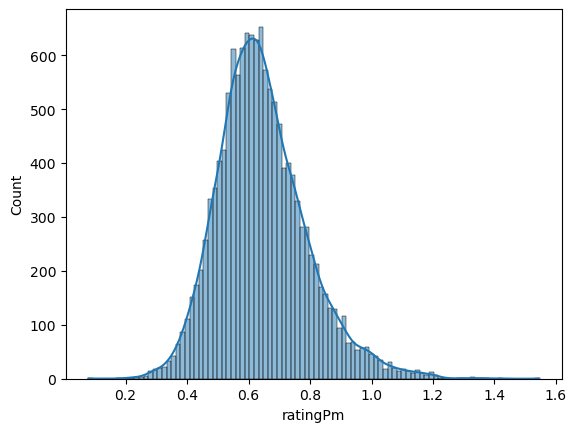

In [115]:
#quick illustration of the distribution of ratings per minute
sns.histplot(df_efficiency['ratingPm'], kde=True)

<Axes: xlabel='salary', ylabel='Count'>

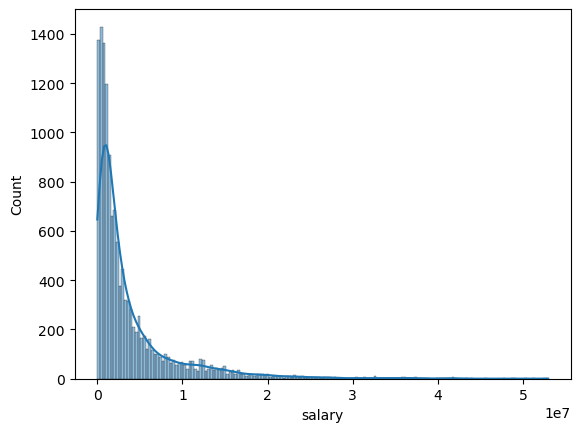

In [116]:
#quick illustration of salary distribution
sns.histplot(df_efficiency['salary'], kde=True)

In [117]:
#function to produce a graph and output the regression coefficients
def efficiency_plot(df, metric, year=None, plot=True):

    #if a season was passed, filter the dataframe
    if year is not None:
        df = df[df.season == year]

    #set feature and prediction variables
    X = df[metric].values.reshape(-1,1)
    y = df['salary'].values

    #linear regression on salary
    lin_model = LinearRegression()
    lin_model.fit(X,y)
    y_pred_lin = lin_model.predict(X)

    #linear regression on log(salary)
    lin_log_model = LinearRegression()

    #apply log to prediction variable
    y_log = y.copy()
    mask = (y != 0)
    y_log[mask] = np.log(y[mask])

    lin_log_model.fit(X,y_log)
    y_pred_log = np.exp(lin_log_model.predict(X))

    if plot:
        fig = px.scatter(
            df,
            x=metric,
            y="salary",
            hover_data=['playerName', 'team', 'season'],
            labels={  # rename axis labels and hover names
                metric : "Efficiency Rating",
                "salary" : "Salary (USD)",
                "playerName" : "Player",
                "team" : "Team"
            }
        )

        #sort for smooth line plotting
        sort_idx = np.argsort(X.flatten())

        #add linear regression line
        fig.add_trace(go.Scatter(
            x=X.flatten()[sort_idx],
            y=y_pred_lin[sort_idx],
            mode="lines",
            name="Linear fit",
            line=dict(color="green")
        ))

        fig.add_trace(go.Scatter(
            x=X.flatten()[sort_idx],
            y=y_pred_log[sort_idx],
            mode="lines",
            name="Log-Linear fit",
            line=dict(color="purple")
        ))

        fig.update_traces(marker=dict(size=6), selector=dict(mode="markers"))
        fig.show()

    return lin_model.coef_[0], lin_log_model.coef_[0]

In [118]:
df_efficiency.head()

,season,playerName,age,team_abbr,games,minutesPg,ftPercent,totalRb,assists,steals,blocks,turnovers,points,rating,ratingPm,ratingTotal,salary
942,1985,Kareem Abdul-Jabbar,37,LAL,79,33.3,0.732,7.9,3.2,0.8,2.1,2.5,22.0,33.5,1.006006,2646.5,1530000.0
943,1985,Alvan Adams,30,PHO,82,26.0,0.883,6.1,3.8,1.4,0.6,2.4,14.7,24.2,0.930769,1984.4,500000.0
944,1985,Mark Aguirre,25,DAL,80,33.7,0.759,6.0,3.1,0.8,0.3,3.2,25.7,32.7,0.970326,2616.0,800000.0
945,1985,Danny Ainge,25,BOS,75,34.2,0.868,3.6,5.3,1.6,0.1,2.0,12.9,21.5,0.628655,1612.5,400000.0
949,1985,John Bagley,24,CLE,81,29.6,0.749,3.6,8.6,1.6,0.1,2.6,9.9,21.2,0.716216,1717.2,209000.0


In [119]:
#20251022_Begin
# efficiency_plot(df_efficiency, 'ratingPm', year=2022)
efficiency_plot(df_efficiency.rename(columns={'team_abbr' : 'team'}), 'ratingPm', year=2022)
#20251022_End

(37740844.79844702, 3.862975268252798)

In [120]:
#generate list of coefficients of linear regression for all available seasons
coeff_lin = [sublist[0] for sublist in (efficiency_plot(df_efficiency, 'ratingPm', year=season, plot=False) for season in range(1995,2024))]

#build graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1995,2023),
                         y=coeff_lin,
                         mode='lines+markers',
                         name='Coeffs',
                         hovertemplate='Season: %{x}<br>Season: %{y}<extra></extra>',
                         line=dict(color='green')))

fig.update_layout(title='Evolution of regression coefficients over the seasons', xaxis_title='Season', yaxis_title='Regression coefficient',
                  hovermode='closest')
fig.show()

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.